sources: https://stackoverflow.com/questions/61297312/finding-the-bounding-boxes-of-different-symbols-letters

https://github.com/OdyAsh/Handwritten-M2L/blob/main/model.ipynb

In [11]:
import numpy as np
import keras
from keras import layers
import cv2
import pickle
import os
import tensorflow as tf 
import math

from matplotlib import pyplot as plt
from pygments.formatters import img

## Segmentation functions


In [39]:
def find_bboxes_iter3(img, return_img_stages = False):
    bboxes = []

    # store state of img after each stage
    img_stages = []
    
    #turn image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_stages.append(gray)
    
    #binarisation
    ret, binary_inv = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    img_stages.append(binary_inv)

    #dilation
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(3, 8))
    imgDilate = cv2.dilate(binary_inv, kernel_dilate, iterations=3)
    img_stages.append(imgDilate)

    #finding contours
    contours, _ = cv2.findContours(imgDilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find bboxes    
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        bboxes.append(bbox)
            
    #draw bbox on img
    bbox_img = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
    img_stages.append(bbox_img) 

    #order bboxes by x value
    bboxes = sorted(bboxes, key=lambda x: x[0])

    arrayLen = len(bboxes)
    noOverlapBBoxes = bboxes.copy()

    # iterate through all bounding box combinations 
    # improvement: use x coordinate and width and y coordinate and height 
    # to check for possible overlaps
    for i in range(arrayLen):
        for j in range(arrayLen):
            if j == i:
                pass
            else:
                IoA = IntersectionOverArea(bboxes[i], bboxes[j])
                if IoA > 0.8:
                    try:
                        noOverlapBBoxes.remove(bboxes[i])
                    except:
                        pass

    if return_img_stages == False:
        return noOverlapBBoxes
    else:
        return noOverlapBBoxes, img_stages

def removeBBoxOverlap(bboxes):
    arrayLen = len(bboxes)
    noOverlapBBoxes = bboxes.copy()


    # iterate through all bounding box combinations 
    # improvement: use x coordinate and width and y coordinate and height 
    # to check for possible overlaps
    for i in range(arrayLen):
        for j in range(arrayLen):
            if j == i:
                pass
            else:
                IoA = IntersectionOverArea(bboxes[i], bboxes[j])
                if IoA > 0.8:
                    try:
                        noOverlapBBoxes.remove(bboxes[i])
                    except:
                        pass
    return noOverlapBBoxes

def IntersectionOverArea(bbox1, bbox2):
    #finding top left and bottom right corner of first bbox
    x1, y1, w1, h1 = bbox1
    A1 = (x1, y1)
    B1 = (x1 + w1, y1 + h1)

    #finding top left and bottom right corner of the second bbox
    x2, y2, w2, h2 = bbox2
    A2 = (x2, y2)
    B2 = (x2 + w2, y2 + h2)

    # Intersection over Union
    # Area of intersection
    # _____________________ x
    # | 
    # |  A1
    # |
    # |
    # |      A2
    # |         B1
    # |
    # |                 B2
    # y

    # x determine the (x, y)-coordinates of the intersection rectangle
    xA = max(A1[0], A2[0])
    yA = max(A1[1], A2[1])
    xB = min(B1[0], B2[0])
    yB = min(B1[1], B2[1])

    # area of the intersection rectangle
    
    interArea = max(0, xB-xA+1) * max(0, yB-yA+1)

    # area of the first input box
    Area1 = (B1[0] - A1[0] +1)*(B1[1] - A1[1]+1)

    # area of intersection/area of box1
    IoA = interArea/float(Area1)
    return IoA

def visualiseBBoxes(img, bboxes, show_bbox_index=False):

    #draw bbox on img
    bbox_img = img.copy()

    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
        
        if show_bbox_index:
            cv2.putText(bbox_img, str(i), (start_point[0], start_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        else:
            pass
    return bbox_img

def load_equations(path):
    equation_imgs = []
    for fileName in os.listdir(path):
        
        img = cv2.imread(os.path.join(path, fileName), cv2.COLOR_BGR2GRAY)
        equation_imgs.append(img)
        
    return equation_imgs

def get_symbol_images(image, bboxes):
    """
    Crops symbols from an image based on bounding boxes, preprocesses them,
    and returns the processed symbols ready for input into a model.

    Parameters:
    - image: The input image from which symbols will be cropped.
    - bboxes: A list of bounding boxes, where each box is represented as (x, y, w, h).

    Returns:
    - symbols: A list of processed symbol images with the shape (45, 45, 1).
    """

    symbols = []  # List to store the processed symbols
    threshold_value = 150  # Threshold value for binary thresholding
    max_value = 255  # Maximum value for thresholding

    for bbox in bboxes:
        # Unpack the bounding box coordinates
        x, y, w, h = bbox

        # Crop the symbol from the image using the bounding box
        symbol = image[y:y+h, x:x+w]

        # Convert the cropped symbol to grayscale
        symbol = cv2.cvtColor(symbol, cv2.COLOR_BGR2GRAY)

        # Calculate the padding to make the image square
        side_length = max(w, h)
        top_pad = (side_length - h) // 2
        bottom_pad = top_pad
        left_pad = (side_length - w) // 2
        right_pad = left_pad

        # Add padding to the image
        symbol = cv2.copyMakeBorder(symbol, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=255)

        # Resize the symbol to a fixed size of 45x45 pixels
        symbol = cv2.resize(symbol, (45, 45), interpolation=cv2.INTER_AREA)

        # Apply binary thresholding to the symbol
        _, symbol = cv2.threshold(symbol, threshold_value, max_value, cv2.THRESH_BINARY)

        # Reshape the symbol to add an extra dimension (45, 45, 1) to fit the model input shape
        symbol = symbol.reshape((45, 45, 1))

        # Append the processed symbol to the list
        symbols.append(symbol)

    return symbols  # Return the list of processed symbols



## Plotting functions

In [13]:

def subplot_bbox_segmentation(imgs):
    
    # Initialise the subplot function using number of rows and columns
    figure, axs = plt.subplots(3, 3)

    for i, image in enumerate(imgs):
        
        # calculating subplot location
        x_pos = (i)%3 
        y_pos = (i)//3

        # finding bbox positions and plotting them on input image
        bboxes = find_bboxes_iter3(image)
        bbox_img = visualiseBBoxes(image, bboxes)

        # plotting image
        axs[x_pos, y_pos].imshow(bbox_img)
        axs[x_pos, y_pos].axis('off')
        axs[x_pos, y_pos].set_title(i+1)

def subplot_bbox_stages(img):
    figure, axs = plt.subplots(3, 3)

    _, img_stages = find_bboxes_iter3(img, return_img_stages=True)
    for i in range(9):
        x_pos = (i)%3 
        y_pos = (i)//3

        try:
            axs[x_pos, y_pos].imshow(img_stages[i])
        except:
            pass
        axs[x_pos, y_pos].axis('off')
        axs[x_pos, y_pos].set_title(i+1)

def oneplot_bbox_segmentation(img):

    bboxes = find_bboxes_iter3(img)
    bbox_img = visualiseBBoxes(img, bboxes)

    plt.imshow(bbox_img)

def oneplot_bbox_stages(img, stage):
    _,  = find_bboxes_iter3(img)
    img_stage = img_stages[stage]

    plt.imshow(img_stage)
    
def subplot_imgs_titles(imgs, titles):
     
    # Initialise the subplot function using number of rows and columns
    n = len(imgs)
    s = math.ceil(math.sqrt(n)) # side length
    figure, axs = plt.subplots(s, s)

    for i in range(s*s):
        x_pos = i%s 
        y_pos = i//s
        axs[x_pos, y_pos].axis('off')


    for i, image in enumerate(imgs):
        
        # calculating subplot location
        x_pos = i%s 
        y_pos = i//s

        # plotting image
        axs[x_pos, y_pos].imshow(image)
        axs[x_pos, y_pos].axis('off')
        axs[x_pos, y_pos].set_title(titles[i])  

def subplot_imgs(imgs):
     
    # Initialise the subplot function using number of rows and columns
    n = len(imgs)
    s = math.ceil(math.sqrt(n)) # side length
    figure, axs = plt.subplots(s, s)

    for i in range(s*s):
        x_pos = i//s 
        y_pos = i%s
        axs[x_pos, y_pos].axis('off')


    for i, image in enumerate(imgs):
        
        # calculating subplot location
        x_pos = i//s 
        y_pos = i%s

        # plotting image
        axs[x_pos, y_pos].imshow(image)
        axs[x_pos, y_pos].axis('off')

## Inference functions

In [14]:
def classify_symbols_from_symbol_imgs(symbol_imgs, model_path):
    model = keras.models.load_model(model_path, compile=True)
    
    classified_symbols = []

    for i in range(len(symbol_imgs)):
        symbol = symbol_imgs[i]
        y_pred = model.predict(tf.expand_dims(symbol, axis=0))
        symbol_class = numsToLatex[y_pred.argmax(axis=-1)[0]]
        classified_symbols.append(symbol_class)

    return classified_symbols


## Global dictionaries

In [15]:
# converts file name to latex

dic = {
    "-": r"-",
    "(": r"(",
    ")": r")",
    "+": r"+",
    "=": r"=",
    "times": r"\times",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    "div": r"\div", 
    "y": r"y", 
    "X": r"x", 
    "C": r"c", 
    "M": r"m"
}


dic_list = [v for k, v in dic.items()]
latexToNums = {k: v for v, k in enumerate(dic_list)}
numsToLatex = {v: k for v, k in enumerate(dic_list)}

## Testing

In [18]:
test_set_1_path = r"test_set1"
test_imgs = load_equations(test_set_1_path)


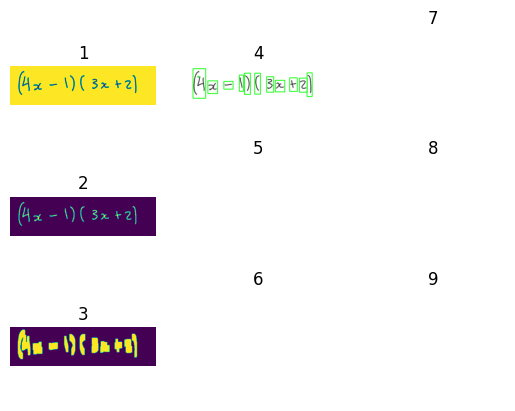

In [ ]:
test_img = test_imgs[4]
subplot_bbox_stages(test_img)

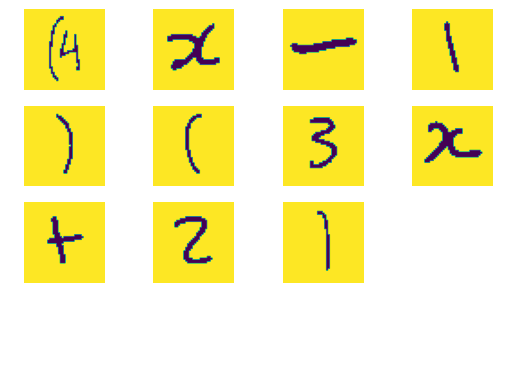

In [20]:
test_img = test_imgs[4]

bboxes = find_bboxes_iter3(test_img)
symbol_images = get_symbol_images(test_img, bboxes)
subplot_imgs(symbol_images)


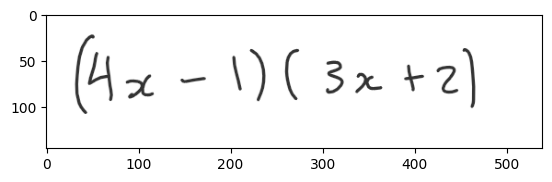

In [21]:
plt.imshow(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━

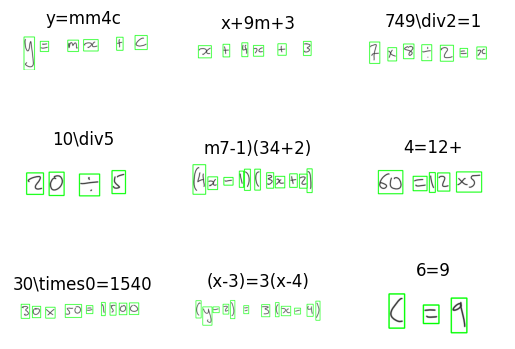

In [40]:
test_set_1_path = r"test_set1"
test_set_2_path = r"test_set2"
test_imgs = load_equations(test_set_1_path)

model_path = r'models\test_set_1_classification_augmented.keras'
equation_strings = [] 
test_imgs_with_bboxes = []

for i in range(len(test_imgs)):

    bboxes = find_bboxes_iter3(test_imgs[i])
    test_img_with_bboxes = visualiseBBoxes(test_imgs[i], bboxes)
    test_imgs_with_bboxes.append(test_img_with_bboxes)


    symbol_imgs = get_symbol_images(test_imgs[i], bboxes)
    symbol_latex_classes = classify_symbols_from_symbol_imgs(symbol_imgs, model_path)
    equation_string = ''.join(symbol_latex_classes)
    equation_strings.append(equation_string)

subplot_imgs_titles(test_imgs_with_bboxes, equation_strings)
  



In [ ]:
test_img = imgs[5]
n=4
model_path = r'models\test_set_1_classification.keras'


# find bounding boxes and crop out symbols
bboxes = find_bboxes_iter3(test_img)
bbox_img = visualiseBBoxes(test_img, bboxes)
symbols = np.array(get_symbol_images(test_img, bboxes))


# figure, axs = plt.subplots(n, n)
# for i, symbol in enumerate(symbols):
#     x_pos = i%n
#     y_pos = i//n
#     axs[x_pos, y_pos].imshow(symbol)



# load model
model = keras.models.load_model(model_path, compile=True)



print(classified_symbols)
plt.imshow(test_img)




NameError: name 'imgs' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
['5', 'x', '-', '-', '2', '0', 'y']


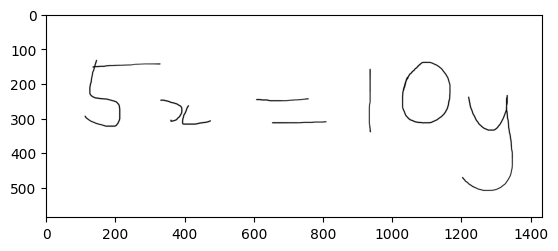

In [ ]:
currently morhping image to fit size

want to keep shapes intact


# Symbol recognition and latex translation

## create test dataset 1. No complex structures like intergrals and fractions. No superscripts or subscripts. 